In [0]:
Dependencies

### Dependencies

In [228]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.grid_search import GridSearchCV
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import cohen_kappa_score, confusion_matrix, accuracy_score, f1_score
from sklearn.model_selection import train_test_split

from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument

from mlxtend.plotting import plot_confusion_matrix

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, wordpunct_tokenize
from nltk.corpus import stopwords

from string import punctuation
from collections import Counter

pd.set_option('max_colwidth',75)

from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, LSTM, Embedding, Input, RepeatVector, Concatenate, Reshape
from keras.layers.merge import concatenate
from keras.optimizers import SGD


[nltk_data] Downloading package stopwords to /content/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /content/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /content/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Preprocesssing

In [0]:
wnl = WordNetLemmatizer()
sw = stopwords.words('english')
def text_preprocessing(t):
    #lowercases
    text = t.lower()
    #remove punctuation
    text = re.sub(pattern=r'['+punctuation+']',repl='',string=text)
    
    #lemmatize
    words = [wnl.lemmatize(w) for w in word_tokenize(text) if w not in sw]
    
    return " ".join(words)
  
  
def onecoldencoder(row):
    for c in y_test.columns:
        if row[c]==1:
            return int(c[-1])

In [0]:
training_variants = pd.read_csv('drive/Colab Notebooks/training_variants', skiprows = 1, names=['ID','Gene','Variation','Class']).set_index('ID')
training_text = pd.read_csv('drive/Colab Notebooks/training_text', sep = '\|\|', header = None, skiprows = 1, 
                            names = ['ID', 'Text'], engine = 'python', encoding = 'utf-8').set_index('ID')

training_data = training_text.dropna().join(training_variants)
X_train = training_data.loc[:,['Gene','Variation','Text']]
y_train = training_data.loc[:,'Class']

### Data loading

In [0]:
X_train.Text = X_train.Text.map(text_preprocessing)
X_test.Text = X_test.Text.map(text_preprocessing)


In [0]:
test_variants = pd.read_csv('drive/Colab Notebooks/test_variants', skiprows = 1, names=['ID','Gene','Variation','Class']).set_index('ID')
test_text = pd.read_csv('drive/Colab Notebooks/test_text', sep = '\|\|', header = None, skiprows = 1, 
                            names = ['ID', 'Text'], engine = 'python', encoding = 'utf-8').set_index('ID')


test_data = test_text.dropna().join(test_variants)
X_test = test_data.loc[:,['Gene','Variation','Text']]

solutions = pd.read_csv('drive/Colab Notebooks/stage1_solution_filtered.csv')
X_test = solutions.join(X_test, how='left').loc[:,['ID','Gene','Variation','Text']].set_index('ID')
y_test = solutions.set_index('ID')

y_test = y_test.reset_index().iloc[:,1:].apply(onecoldencoder,1)
y_test.index = solutions.index

# Clasification on original test set (mislabeled?)

### Preparation for Doc2Vec: Tagging documents

In [0]:
tagged_descriptions_train = [TaggedDocument(row.Text.split(), [row.Gene+'_'+row.Variation]) for i, row in X_train.iterrows()]
tagged_descriptions_test = [TaggedDocument(row.Text.split(), [row.Gene+'_'+row.Variation]) for i, row in X_test.iterrows()]
  

### Training Doc2Vec, stacking all vectorizations in a matrix

---



In [0]:
d2v_train = Doc2Vec(alpha=0.025, min_alpha=0.025)
d2v_train.build_vocab(tagged_descriptions_train)
d2v_train.train(tagged_descriptions_train, total_examples=2100, epochs=d2v_train.epochs)

d2v_test = Doc2Vec(alpha=0.025, min_alpha=0.025)
d2v_test.build_vocab(tagged_descriptions_test)
d2v_test.train(tagged_descriptions_test, total_examples=2100, epochs=d2v_test.epochs)



In [0]:
docvec_matrix_train = np.vstack([d2v_train.docvecs[X_train.Gene[i]+'_'+X_train.Variation[i]] for i,row in X_train.iterrows()])
docvec_matrix_test = np.vstack([d2v_test.docvecs[X_test.Gene[i]+'_'+X_test.Variation[i]] for i,row in X_test.iterrows()])

(3316, 3)

In [0]:
svd_train = TruncatedSVD(20)
gene_hotsvd_train = svd_train.fit_transform(pd.get_dummies(X_train.Gene).values)
variation_hotsvd_train = svd_train.fit_transform(pd.get_dummies(X_train.Variation).values)

svd_test = TruncatedSVD(20)
gene_hotsvd_test = svd_test.fit_transform(pd.get_dummies(X_test.Gene).values)
variation_hotsvd_test = svd_test.fit_transform(pd.get_dummies(X_test.Variation).values)





In [0]:
X_train_engineered = pd.DataFrame(np.hstack((gene_hotsvd_train, variation_hotsvd_train, docvec_matrix_train)))
X_train_engineered.index = X_train.index

X_test_engineered = pd.DataFrame(np.hstack((gene_hotsvd_test, variation_hotsvd_test, docvec_matrix_test)))
X_test_engineered.index = X_test.index

In [0]:
y_train_engineered = pd.get_dummies(y_train)

# Neural Network architectures


In [0]:


def build_net():
    input1 = Input(shape=(140,))
    dense1 = Dense(256, kernel_initializer='normal', activation='relu')(input1)
    drop1 = Dropout(0.25)(dense1)
    dense2 = Dense(256, kernel_initializer='normal', activation='relu')(drop1)
    drop2 = Dropout(0.5)(dense2)
    dense3 = Dense(64, kernel_initializer='normal', activation='relu')(drop2)
    smax = Dense(9, kernel_initializer='normal', activation="softmax")(dense3)
    
    sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    
    model = Model(inputs=input1 ,outputs=smax)
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    return model
  

def build_lstm():

    genvar_input = Input(shape=(40,))
    genvar_dense1 = Dense(128, kernel_initializer='normal', activation='relu')(genvar_input)
    genvar_drop1 = Dropout(0.25)(genvar_dense1)
    genvar_dense2 = Dense(128, kernel_initializer='normal', activation='relu')(genvar_drop1)
    
    text_input = Input(shape=(100,))
    text_reshape = Reshape((100,1))(text_input)
    text_lstm = LSTM(200, input_shape=(100,1), recurrent_dropout = 0.2)(text_reshape)
    
    merged = concatenate([genvar_dense2, text_lstm])

    merged_dense1 = Dense(256, kernel_initializer='normal', activation='relu')(merged)
    merged_dense2 = Dense(64, kernel_initializer='normal', activation='relu')(merged_dense1)
    smax = Dense(9, kernel_initializer='normal', activation="softmax")(merged_dense2)
    
    model = Model(inputs=[genvar_input,text_input], outputs=smax)
    
    sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)  
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    return model

In [0]:
lstm02 = build_lstm()

In [153]:
#lstm01 = build_lstm()
lstm01_callbacks = lstm01.fit([X_train_engineered.iloc[:,:40],X_train_engineered.iloc[:,40:]], y_train_engineered,
                             validation_split=0.2, epochs=50, batch_size=64)

Train on 2652 samples, validate on 664 samples
Epoch 1/50
2652/2652 [==============================] - 12s 4ms/step - loss: 0.5318 - acc: 0.8032 - val_loss: 3.0371 - val_acc: 0.3660
Epoch 2/50
2652/2652 [==============================] - 11s 4ms/step - loss: 0.5315 - acc: 0.8058 - val_loss: 3.3221 - val_acc: 0.3419
Epoch 3/50
2652/2652 [==============================] - 12s 4ms/step - loss: 0.5344 - acc: 0.8051 - val_loss: 3.0017 - val_acc: 0.3810
Epoch 4/50
2652/2652 [==============================] - 12s 4ms/step - loss: 0.4838 - acc: 0.8216 - val_loss: 3.1514 - val_acc: 0.3569
Epoch 5/50
2652/2652 [==============================] - 11s 4ms/step - loss: 0.4878 - acc: 0.8198 - val_loss: 3.4160 - val_acc: 0.3584
Epoch 6/50
 896/2652 [=========>....................] - ETA: 7s - loss: 0.4879 - acc: 0.8181

2652/2652 [==============================] - 11s 4ms/step - loss: 0.4586 - acc: 0.8318 - val_loss: 3.8906 - val_acc: 0.3238
Epoch 7/50
2652/2652 [==============================] - 11s 4ms/step - loss: 0.5067 - acc: 0.8111 - val_loss: 3.3527 - val_acc: 0.3449
Epoch 8/50
2652/2652 [==============================] - 11s 4ms/step - loss: 0.4422 - acc: 0.8371 - val_loss: 3.6525 - val_acc: 0.3419
Epoch 9/50
2652/2652 [==============================] - 11s 4ms/step - loss: 0.4460 - acc: 0.8341 - val_loss: 3.5034 - val_acc: 0.3554
Epoch 10/50
2652/2652 [==============================] - 11s 4ms/step - loss: 0.4106 - acc: 0.8420 - val_loss: 3.6683 - val_acc: 0.3630
Epoch 11/50
2112/2652 [======================>.......] - ETA: 2s - loss: 0.4042 - acc: 0.8537

2652/2652 [==============================] - 11s 4ms/step - loss: 0.4123 - acc: 0.8522 - val_loss: 4.3363 - val_acc: 0.2892
Epoch 12/50
2652/2652 [==============================] - 11s 4ms/step - loss: 0.4041 - acc: 0.8537 - val_loss: 3.7692 - val_acc: 0.3524
Epoch 13/50
2652/2652 [==============================] - 11s 4ms/step - loss: 0.3526 - acc: 0.8718 - val_loss: 3.7633 - val_acc: 0.3449
Epoch 14/50
2652/2652 [==============================] - 11s 4ms/step - loss: 0.3730 - acc: 0.8688 - val_loss: 4.0266 - val_acc: 0.3735
Epoch 15/50
2652/2652 [==============================] - 11s 4ms/step - loss: 0.3545 - acc: 0.8725 - val_loss: 3.8875 - val_acc: 0.3599
Epoch 16/50
2176/2652 [=======================>......] - ETA: 1s - loss: 0.3463 - acc: 0.8617

2652/2652 [==============================] - 11s 4ms/step - loss: 0.3556 - acc: 0.8616 - val_loss: 3.8370 - val_acc: 0.3614
Epoch 17/50
2652/2652 [==============================] - 12s 4ms/step - loss: 0.3580 - acc: 0.8703 - val_loss: 4.2140 - val_acc: 0.3434
Epoch 18/50
2652/2652 [==============================] - 11s 4ms/step - loss: 0.4780 - acc: 0.8179 - val_loss: 3.7522 - val_acc: 0.3389
Epoch 19/50
2652/2652 [==============================] - 12s 4ms/step - loss: 0.4138 - acc: 0.8428 - val_loss: 3.8921 - val_acc: 0.3449
Epoch 20/50
2652/2652 [==============================] - 12s 4ms/step - loss: 0.3228 - acc: 0.8861 - val_loss: 3.9722 - val_acc: 0.3599
Epoch 21/50
2176/2652 [=======================>......] - ETA: 1s - loss: 0.3232 - acc: 0.8883

2652/2652 [==============================] - 12s 4ms/step - loss: 0.3263 - acc: 0.8854 - val_loss: 4.1935 - val_acc: 0.3494
Epoch 22/50
2652/2652 [==============================] - 11s 4ms/step - loss: 0.3021 - acc: 0.8918 - val_loss: 4.1682 - val_acc: 0.3690
Epoch 23/50
2652/2652 [==============================] - 11s 4ms/step - loss: 0.2663 - acc: 0.9038 - val_loss: 4.3156 - val_acc: 0.3569
Epoch 24/50
2652/2652 [==============================] - 11s 4ms/step - loss: 0.2485 - acc: 0.9114 - val_loss: 4.4563 - val_acc: 0.3660
Epoch 25/50
2652/2652 [==============================] - 11s 4ms/step - loss: 0.3498 - acc: 0.8733 - val_loss: 4.4746 - val_acc: 0.3599
Epoch 26/50
2176/2652 [=======================>......] - ETA: 1s - loss: 0.3572 - acc: 0.8686

2652/2652 [==============================] - 11s 4ms/step - loss: 0.3462 - acc: 0.8722 - val_loss: 4.2171 - val_acc: 0.3630
Epoch 27/50
2652/2652 [==============================] - 11s 4ms/step - loss: 0.3184 - acc: 0.8842 - val_loss: 4.5607 - val_acc: 0.3464
Epoch 28/50
2652/2652 [==============================] - 11s 4ms/step - loss: 0.2589 - acc: 0.9076 - val_loss: 4.2930 - val_acc: 0.3660
Epoch 29/50
2652/2652 [==============================] - 12s 4ms/step - loss: 0.2188 - acc: 0.9223 - val_loss: 4.7338 - val_acc: 0.3328
Epoch 30/50
2652/2652 [==============================] - 12s 4ms/step - loss: 0.2115 - acc: 0.9272 - val_loss: 4.4147 - val_acc: 0.3705
Epoch 31/50
2176/2652 [=======================>......] - ETA: 1s - loss: 0.2794 - acc: 0.9021

2652/2652 [==============================] - 11s 4ms/step - loss: 0.2771 - acc: 0.9020 - val_loss: 4.6999 - val_acc: 0.3584
Epoch 32/50
2652/2652 [==============================] - 11s 4ms/step - loss: 0.2468 - acc: 0.9129 - val_loss: 4.6208 - val_acc: 0.3569
Epoch 33/50
2652/2652 [==============================] - 11s 4ms/step - loss: 0.1979 - acc: 0.9306 - val_loss: 4.8411 - val_acc: 0.3584
Epoch 34/50
2652/2652 [==============================] - 11s 4ms/step - loss: 0.1870 - acc: 0.9333 - val_loss: 5.0103 - val_acc: 0.3389
Epoch 35/50
2652/2652 [==============================] - 11s 4ms/step - loss: 0.1729 - acc: 0.9400 - val_loss: 4.7107 - val_acc: 0.3735
Epoch 36/50
2176/2652 [=======================>......] - ETA: 1s - loss: 0.1610 - acc: 0.9485

2652/2652 [==============================] - 11s 4ms/step - loss: 0.1775 - acc: 0.9419 - val_loss: 4.9945 - val_acc: 0.3449
Epoch 37/50
2652/2652 [==============================] - 11s 4ms/step - loss: 0.2263 - acc: 0.9193 - val_loss: 4.9525 - val_acc: 0.3584
Epoch 38/50
2652/2652 [==============================] - 11s 4ms/step - loss: 0.2499 - acc: 0.9114 - val_loss: 4.9412 - val_acc: 0.3569
Epoch 39/50
2652/2652 [==============================] - 11s 4ms/step - loss: 0.1923 - acc: 0.9306 - val_loss: 5.1488 - val_acc: 0.3404
Epoch 40/50
2652/2652 [==============================] - 11s 4ms/step - loss: 0.1745 - acc: 0.9393 - val_loss: 5.2623 - val_acc: 0.3328
Epoch 41/50
2176/2652 [=======================>......] - ETA: 1s - loss: 0.1627 - acc: 0.9485

2652/2652 [==============================] - 12s 4ms/step - loss: 0.1656 - acc: 0.9483 - val_loss: 5.0654 - val_acc: 0.3449
Epoch 42/50
2652/2652 [==============================] - 11s 4ms/step - loss: 0.1369 - acc: 0.9551 - val_loss: 5.3206 - val_acc: 0.3178
Epoch 43/50
2652/2652 [==============================] - 12s 4ms/step - loss: 0.1381 - acc: 0.9529 - val_loss: 5.5680 - val_acc: 0.3178
Epoch 44/50
2652/2652 [==============================] - 11s 4ms/step - loss: 0.1810 - acc: 0.9306 - val_loss: 5.3991 - val_acc: 0.3569
Epoch 45/50
2652/2652 [==============================] - 11s 4ms/step - loss: 0.2143 - acc: 0.9235 - val_loss: 5.1722 - val_acc: 0.3298
Epoch 46/50
2176/2652 [=======================>......] - ETA: 1s - loss: 0.1832 - acc: 0.9380

2652/2652 [==============================] - 11s 4ms/step - loss: 0.1826 - acc: 0.9367 - val_loss: 5.3265 - val_acc: 0.3283
Epoch 47/50
2652/2652 [==============================] - 12s 4ms/step - loss: 0.1597 - acc: 0.9461 - val_loss: 5.1796 - val_acc: 0.3208
Epoch 48/50
2652/2652 [==============================] - 12s 4ms/step - loss: 0.1431 - acc: 0.9521 - val_loss: 5.2371 - val_acc: 0.3479
Epoch 49/50
2652/2652 [==============================] - 12s 4ms/step - loss: 0.1160 - acc: 0.9604 - val_loss: 5.3181 - val_acc: 0.3494
Epoch 50/50
2652/2652 [==============================] - 11s 4ms/step - loss: 0.0907 - acc: 0.9695 - val_loss: 5.7987 - val_acc: 0.3117


In [134]:
net01 = build_net()
net01_callbacks = net01.fit(X_train_engineered, y_train_engineered, validation_split=0.2, epochs=150, batch_size=64)


Train on 2652 samples, validate on 664 samples
Epoch 1/150
2652/2652 [==============================] - 2s 762us/step - loss: 1.9671 - acc: 0.2383 - val_loss: 1.9171 - val_acc: 0.3283
Epoch 2/150
2652/2652 [==============================] - 0s 112us/step - loss: 1.8038 - acc: 0.3194 - val_loss: 1.8283 - val_acc: 0.3268
Epoch 3/150
2652/2652 [==============================] - 0s 116us/step - loss: 1.7113 - acc: 0.3839 - val_loss: 1.7566 - val_acc: 0.3042
Epoch 4/150
2652/2652 [==============================] - 0s 121us/step - loss: 1.6297 - acc: 0.4125 - val_loss: 1.6767 - val_acc: 0.3283
Epoch 5/150
2652/2652 [==============================] - 0s 125us/step - loss: 1.5745 - acc: 0.4310 - val_loss: 1.6675 - val_acc: 0.3253
Epoch 6/150
2652/2652 [==============================] - 0s 122us/step - loss: 1.5456 - acc: 0.4340 - val_loss: 1.6465 - val_acc: 0.3283
Epoch 7/150
2652/2652 [==============================] - 0s 119us/step - loss: 1.4914 - acc: 0.4604 - val_loss: 1.6824 - val_acc: 0

2652/2652 [==============================] - 0s 116us/step - loss: 1.3183 - acc: 0.5140 - val_loss: 1.6907 - val_acc: 0.3283
Epoch 15/150
2652/2652 [==============================] - 0s 118us/step - loss: 1.2619 - acc: 0.5317 - val_loss: 1.8037 - val_acc: 0.3223
Epoch 16/150
2652/2652 [==============================] - 0s 117us/step - loss: 1.2578 - acc: 0.5313 - val_loss: 1.7198 - val_acc: 0.3419
Epoch 17/150
2652/2652 [==============================] - 0s 120us/step - loss: 1.2339 - acc: 0.5343 - val_loss: 1.7831 - val_acc: 0.3268
Epoch 18/150
2652/2652 [==============================] - 0s 124us/step - loss: 1.2078 - acc: 0.5445 - val_loss: 1.7166 - val_acc: 0.3419
Epoch 19/150
2652/2652 [==============================] - 0s 117us/step - loss: 1.2058 - acc: 0.5528 - val_loss: 1.7048 - val_acc: 0.3479
Epoch 20/150
2652/2652 [==============================] - 0s 118us/step - loss: 1.1749 - acc: 0.5517 - val_loss: 1.8033 - val_acc: 0.3193
Epoch 21/150
2652/2652 [=======================

2652/2652 [==============================] - 0s 118us/step - loss: 1.0304 - acc: 0.6180 - val_loss: 1.9218 - val_acc: 0.3645
Epoch 28/150
2652/2652 [==============================] - 0s 125us/step - loss: 1.0364 - acc: 0.6090 - val_loss: 1.9007 - val_acc: 0.3434
Epoch 29/150
2652/2652 [==============================] - 0s 120us/step - loss: 1.0187 - acc: 0.6048 - val_loss: 1.8463 - val_acc: 0.3494
Epoch 30/150
2652/2652 [==============================] - 0s 122us/step - loss: 1.0122 - acc: 0.6188 - val_loss: 2.0343 - val_acc: 0.3690
Epoch 31/150
2652/2652 [==============================] - 0s 120us/step - loss: 0.9764 - acc: 0.6267 - val_loss: 1.9794 - val_acc: 0.3434
Epoch 32/150
2652/2652 [==============================] - 0s 119us/step - loss: 0.9764 - acc: 0.6259 - val_loss: 1.9207 - val_acc: 0.3660
Epoch 33/150
2652/2652 [==============================] - 0s 118us/step - loss: 0.9497 - acc: 0.6448 - val_loss: 2.0102 - val_acc: 0.3373
Epoch 34/150
2652/2652 [=======================

2652/2652 [==============================] - 0s 122us/step - loss: 0.8604 - acc: 0.6874 - val_loss: 2.1397 - val_acc: 0.3464
Epoch 41/150
2652/2652 [==============================] - 0s 124us/step - loss: 0.8413 - acc: 0.6742 - val_loss: 2.0747 - val_acc: 0.3569
Epoch 42/150
2652/2652 [==============================] - 0s 120us/step - loss: 0.8150 - acc: 0.6904 - val_loss: 2.1295 - val_acc: 0.3675
Epoch 43/150
2652/2652 [==============================] - 0s 120us/step - loss: 0.8494 - acc: 0.6867 - val_loss: 2.1060 - val_acc: 0.3283
Epoch 44/150
2652/2652 [==============================] - 0s 118us/step - loss: 0.8175 - acc: 0.6991 - val_loss: 2.0818 - val_acc: 0.3569
Epoch 45/150
2652/2652 [==============================] - 0s 122us/step - loss: 0.8140 - acc: 0.6968 - val_loss: 2.0490 - val_acc: 0.3645
Epoch 46/150
2652/2652 [==============================] - 0s 121us/step - loss: 0.8133 - acc: 0.6991 - val_loss: 2.0663 - val_acc: 0.3750
Epoch 47/150
2652/2652 [=======================

Epoch 54/150
2652/2652 [==============================] - 0s 122us/step - loss: 0.7313 - acc: 0.7168 - val_loss: 2.2158 - val_acc: 0.3645
Epoch 55/150
2652/2652 [==============================] - 0s 119us/step - loss: 0.7249 - acc: 0.7391 - val_loss: 2.3573 - val_acc: 0.3614
Epoch 56/150
2652/2652 [==============================] - 0s 124us/step - loss: 0.6998 - acc: 0.7345 - val_loss: 2.2884 - val_acc: 0.3886
Epoch 57/150
2652/2652 [==============================] - 0s 119us/step - loss: 0.7151 - acc: 0.7323 - val_loss: 2.3630 - val_acc: 0.3855
Epoch 58/150
2652/2652 [==============================] - 0s 119us/step - loss: 0.6943 - acc: 0.7406 - val_loss: 2.3022 - val_acc: 0.3825
Epoch 59/150
2652/2652 [==============================] - 0s 110us/step - loss: 0.6792 - acc: 0.7353 - val_loss: 2.4120 - val_acc: 0.3449
Epoch 60/150
2652/2652 [==============================] - 0s 119us/step - loss: 0.6820 - acc: 0.7281 - val_loss: 2.4343 - val_acc: 0.3313
Epoch 61/150
2652/2652 [==========

2652/2652 [==============================] - 0s 122us/step - loss: 0.6804 - acc: 0.7455 - val_loss: 2.5565 - val_acc: 0.3554
Epoch 69/150
2652/2652 [==============================] - 0s 121us/step - loss: 0.6245 - acc: 0.7805 - val_loss: 2.5355 - val_acc: 0.3554
Epoch 70/150
2652/2652 [==============================] - 0s 121us/step - loss: 0.6255 - acc: 0.7628 - val_loss: 2.3968 - val_acc: 0.3750
Epoch 71/150
2652/2652 [==============================] - 0s 118us/step - loss: 0.6420 - acc: 0.7609 - val_loss: 2.5538 - val_acc: 0.3645
Epoch 72/150
2652/2652 [==============================] - 0s 124us/step - loss: 0.6154 - acc: 0.7677 - val_loss: 2.5160 - val_acc: 0.3569
Epoch 73/150
2652/2652 [==============================] - 0s 118us/step - loss: 0.6097 - acc: 0.7673 - val_loss: 2.6443 - val_acc: 0.3404
Epoch 74/150
2652/2652 [==============================] - 0s 120us/step - loss: 0.5999 - acc: 0.7768 - val_loss: 2.5575 - val_acc: 0.3584
Epoch 75/150
2652/2652 [=======================

Epoch 82/150
2652/2652 [==============================] - 0s 123us/step - loss: 0.5839 - acc: 0.7866 - val_loss: 2.8372 - val_acc: 0.3434
Epoch 83/150
2652/2652 [==============================] - 0s 120us/step - loss: 0.5778 - acc: 0.7843 - val_loss: 2.6771 - val_acc: 0.3614
Epoch 84/150
2652/2652 [==============================] - 0s 122us/step - loss: 0.5527 - acc: 0.7911 - val_loss: 2.6559 - val_acc: 0.3735
Epoch 85/150
2652/2652 [==============================] - 0s 122us/step - loss: 0.5699 - acc: 0.7873 - val_loss: 2.8572 - val_acc: 0.3584
Epoch 86/150
2652/2652 [==============================] - 0s 119us/step - loss: 0.5906 - acc: 0.7738 - val_loss: 2.8582 - val_acc: 0.3343
Epoch 87/150
2652/2652 [==============================] - 0s 121us/step - loss: 0.5418 - acc: 0.8054 - val_loss: 2.6477 - val_acc: 0.3584
Epoch 88/150
2652/2652 [==============================] - 0s 118us/step - loss: 0.5510 - acc: 0.7937 - val_loss: 2.7436 - val_acc: 0.3554
Epoch 89/150
2652/2652 [==========

2652/2652 [==============================] - 0s 118us/step - loss: 0.5412 - acc: 0.8035 - val_loss: 2.8418 - val_acc: 0.3419
Epoch 96/150
2652/2652 [==============================] - 0s 117us/step - loss: 0.5420 - acc: 0.7945 - val_loss: 2.6849 - val_acc: 0.3630
Epoch 97/150
2652/2652 [==============================] - 0s 119us/step - loss: 0.5140 - acc: 0.8088 - val_loss: 2.8109 - val_acc: 0.3750
Epoch 98/150
2652/2652 [==============================] - 0s 120us/step - loss: 0.5384 - acc: 0.8032 - val_loss: 2.8228 - val_acc: 0.3690
Epoch 99/150
2652/2652 [==============================] - 0s 118us/step - loss: 0.5249 - acc: 0.8103 - val_loss: 2.9940 - val_acc: 0.3494
Epoch 100/150
2652/2652 [==============================] - 0s 120us/step - loss: 0.5305 - acc: 0.8111 - val_loss: 2.6976 - val_acc: 0.3539
Epoch 101/150
2652/2652 [==============================] - 0s 120us/step - loss: 0.5255 - acc: 0.8051 - val_loss: 2.7617 - val_acc: 0.3494
Epoch 102/150
2652/2652 [====================

2652/2652 [==============================] - 0s 118us/step - loss: 0.4898 - acc: 0.8100 - val_loss: 3.1539 - val_acc: 0.3599
Epoch 110/150
2652/2652 [==============================] - 0s 121us/step - loss: 0.5054 - acc: 0.8160 - val_loss: 3.1758 - val_acc: 0.3630
Epoch 111/150
2652/2652 [==============================] - 0s 119us/step - loss: 0.4724 - acc: 0.8262 - val_loss: 3.2120 - val_acc: 0.3660
Epoch 112/150
2652/2652 [==============================] - 0s 123us/step - loss: 0.4738 - acc: 0.8269 - val_loss: 3.0617 - val_acc: 0.3765
Epoch 113/150
2652/2652 [==============================] - 0s 121us/step - loss: 0.4687 - acc: 0.8284 - val_loss: 3.1761 - val_acc: 0.3584
Epoch 114/150
2652/2652 [==============================] - 0s 122us/step - loss: 0.4856 - acc: 0.8209 - val_loss: 3.0907 - val_acc: 0.3509
Epoch 115/150
2652/2652 [==============================] - 0s 121us/step - loss: 0.4769 - acc: 0.8224 - val_loss: 2.8755 - val_acc: 0.3735
Epoch 116/150
2652/2652 [================

2652/2652 [==============================] - 0s 118us/step - loss: 0.4525 - acc: 0.8311 - val_loss: 3.1922 - val_acc: 0.3554
Epoch 124/150
2652/2652 [==============================] - 0s 125us/step - loss: 0.4602 - acc: 0.8265 - val_loss: 3.0792 - val_acc: 0.3479
Epoch 125/150
2652/2652 [==============================] - 0s 122us/step - loss: 0.4768 - acc: 0.8201 - val_loss: 2.9480 - val_acc: 0.3614
Epoch 126/150
2652/2652 [==============================] - 0s 120us/step - loss: 0.4507 - acc: 0.8213 - val_loss: 3.1346 - val_acc: 0.3599
Epoch 127/150
2652/2652 [==============================] - 0s 120us/step - loss: 0.4540 - acc: 0.8360 - val_loss: 3.2638 - val_acc: 0.3449
Epoch 128/150
2652/2652 [==============================] - 0s 120us/step - loss: 0.4530 - acc: 0.8299 - val_loss: 3.2230 - val_acc: 0.3404
Epoch 129/150
2652/2652 [==============================] - 0s 122us/step - loss: 0.4636 - acc: 0.8311 - val_loss: 3.0468 - val_acc: 0.3509
Epoch 130/150
2652/2652 [================

2652/2652 [==============================] - 0s 122us/step - loss: 0.4282 - acc: 0.8443 - val_loss: 3.1979 - val_acc: 0.3554
Epoch 138/150
2652/2652 [==============================] - 0s 121us/step - loss: 0.4278 - acc: 0.8390 - val_loss: 3.2090 - val_acc: 0.3464
Epoch 139/150
2652/2652 [==============================] - 0s 118us/step - loss: 0.4227 - acc: 0.8435 - val_loss: 3.2590 - val_acc: 0.3599
Epoch 140/150
2652/2652 [==============================] - 0s 118us/step - loss: 0.4141 - acc: 0.8480 - val_loss: 3.2571 - val_acc: 0.3524
Epoch 141/150
2652/2652 [==============================] - 0s 121us/step - loss: 0.4359 - acc: 0.8299 - val_loss: 3.2425 - val_acc: 0.3509
Epoch 142/150
2652/2652 [==============================] - 0s 124us/step - loss: 0.4659 - acc: 0.8333 - val_loss: 3.0492 - val_acc: 0.3720
Epoch 143/150
2652/2652 [==============================] - 0s 122us/step - loss: 0.4441 - acc: 0.8318 - val_loss: 3.2590 - val_acc: 0.3404
Epoch 144/150
2652/2652 [================

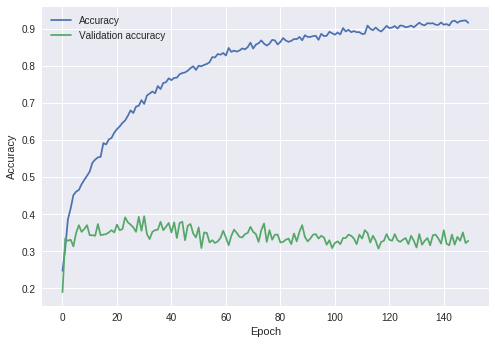

In [91]:
plt.plot(net01_callbacks.history['acc'], label='Accuracy')
plt.plot(net01_callbacks.history['val_acc'], label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
#plt.show()

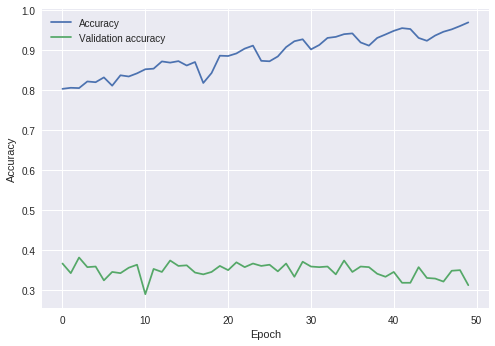

In [154]:
plt.plot(lstm01_callbacks.history['acc'], label='Accuracy')
plt.plot(lstm01_callbacks.history['val_acc'], label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
#plt.show()

In [0]:
y_pred_train = net01.predict(X_train_engineered)
y_pred_test =  net01.predict(X_test_engineered)

In [0]:
y_pred_train_classes = net01.predict_classes(X_train_engineered)
y_pred_test_classes =  net01.predict_classes(X_test_engineered)
#y_train_engineered.reset_index().iloc[:,1:].apply(onecoldencoder,1)#lstm.predict_classes(X_train_engineered)

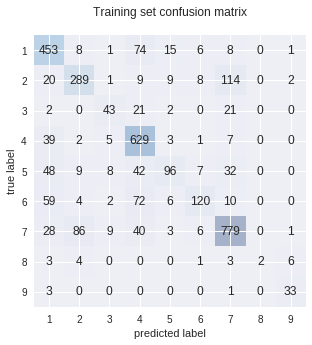

Accuracy:  0.7370325693606755
Cohen Kappa score:  0.672377495010404


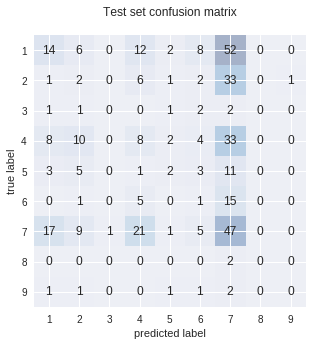

Accuracy:  0.07065217391304347
Cohen Kappa score:  -0.026421395163509054


In [80]:

plot_confusion_matrix(confusion_matrix(y_train, y_pred_train_classes + 1), figsize=(5,5))
plt.title('Training set confusion matrix')
plt.xticks(range(0,9), range(1,10))
plt.yticks(range(0,9), range(1,10))

plt.show()

print('Accuracy: ', accuracy_score(y_pred=y_pred_train_classes + 1,
                                   y_true=y_train))
print('Cohen Kappa score: ', cohen_kappa_score(labels=range(1,10),
                  y1 = y_pred_train_classes + 1, 
                  y2 = y_train))


plot_confusion_matrix(confusion_matrix(y_test, y_pred_test_classes + 1),figsize=(5,5))

plt.title('Test set confusion matrix')
plt.xticks(range(0,9), range(1,10))
plt.yticks(range(0,9), range(1,10))

plt.show()

print('Accuracy: ', accuracy_score(y_pred=y_pred_test_classes,
                                   y_true=y_test))
print('Cohen Kappa score: ', cohen_kappa_score(labels=range(1,10),
                  y1 = y_pred_test_classes + 1, 
                  y2 = y_test))

# Classification of new test set (split from original training set)

In [0]:
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_train, y_train)

## Doc2Vec

In [0]:
tagged_descriptions_train_new = [TaggedDocument(row.Text.split(), [row.Gene+'_'+row.Variation]) for i, row in X_train_new.iterrows()]
tagged_descriptions_test_new = [TaggedDocument(row.Text.split(), [row.Gene+'_'+row.Variation]) for i, row in X_test_new.iterrows()]

In [0]:
d2v_train_new = Doc2Vec(alpha=0.025, min_alpha=0.025)
d2v_train_new.build_vocab(tagged_descriptions_train_new)
d2v_train_new.train(tagged_descriptions_train_new, total_examples=2100, epochs=d2v_train_new.epochs)

d2v_test_new = Doc2Vec(alpha=0.025, min_alpha=0.025)
d2v_test_new.build_vocab(tagged_descriptions_test_new)
d2v_test_new.train(tagged_descriptions_test_new, total_examples=2100, epochs=d2v_test_new.epochs)


In [0]:
docvec_matrix_train_new = np.vstack([d2v_train_new.docvecs[X_train_new.Gene[i]+'_'+X_train_new.Variation[i]] for i,row in X_train_new.iterrows()])
docvec_matrix_test_new = np.vstack([d2v_test_new.docvecs[X_test_new.Gene[i]+'_'+X_test_new.Variation[i]] for i,row in X_test_new.iterrows()])

## SVD

In [0]:
X_hot = pd.get_dummies(pd.concat((X_train_new.loc[:,['Gene','Variation']],X_test_new.loc[:,['Gene','Variation']])))#.iloc[2487:2491,:]
X_train_hot = X_hot.iloc[:2487,:]
X_test_hot = X_hot.iloc[2487:,:]


svd = TruncatedSVD(40)
svd.fit(X_train_hot)

gen_var_train =svd.transform(X_train_hot)
gen_var_test = svd.transform(X_test_hot)


In [0]:
X_train_new_engineered = pd.DataFrame(np.hstack((gen_var_train, docvec_matrix_train_new)))
X_train_new_engineered.index = X_train_new.index

X_test_new_engineered = pd.DataFrame(np.hstack((gen_var_test, docvec_matrix_test_new)))
X_test_new_engineered.index = X_test_new.index

In [0]:
y_train_new_engineered = pd.get_dummies(y_train_new)
y_test_new_engineered = pd.get_dummies(y_test_new)

# Neural network fitting

In [209]:
#lstm02 = build_lstm()
lstm02_callbacks3 = lstm02.fit([X_train_new_engineered.iloc[:,:40],X_train_new_engineered.iloc[:,40:]], y_train_new_engineered,
                             validation_split=0.2, epochs=150, batch_size=64)

Train on 1989 samples, validate on 498 samples
Epoch 1/150
1989/1989 [==============================] - 10s 5ms/step - loss: 0.3372 - acc: 0.8703 - val_loss: 2.1686 - val_acc: 0.5643
Epoch 2/150
1989/1989 [==============================] - 10s 5ms/step - loss: 0.3312 - acc: 0.8773 - val_loss: 2.1933 - val_acc: 0.5482
Epoch 3/150
1989/1989 [==============================] - 10s 5ms/step - loss: 0.3103 - acc: 0.8829 - val_loss: 2.2405 - val_acc: 0.5522
Epoch 4/150
1989/1989 [==============================] - 10s 5ms/step - loss: 0.3133 - acc: 0.8763 - val_loss: 2.4817 - val_acc: 0.5181
Epoch 5/150
1989/1989 [==============================] - 10s 5ms/step - loss: 0.4133 - acc: 0.8542 - val_loss: 2.1449 - val_acc: 0.5723
Epoch 6/150
1989/1989 [==============================] - 10s 5ms/step - loss: 0.3276 - acc: 0.8753 - val_loss: 2.1918 - val_acc: 0.5683
Epoch 7/150
 256/1989 [==>...........................] - ETA: 8s - loss: 0.3404 - acc: 0.8633

1989/1989 [==============================] - 10s 5ms/step - loss: 0.3441 - acc: 0.8693 - val_loss: 2.4282 - val_acc: 0.5060
Epoch 8/150
1989/1989 [==============================] - 10s 5ms/step - loss: 0.4366 - acc: 0.8431 - val_loss: 2.2096 - val_acc: 0.5582
Epoch 9/150
1989/1989 [==============================] - 10s 5ms/step - loss: 0.3361 - acc: 0.8758 - val_loss: 2.2517 - val_acc: 0.5301
Epoch 10/150
1989/1989 [==============================] - 10s 5ms/step - loss: 0.3466 - acc: 0.8743 - val_loss: 2.1096 - val_acc: 0.5542
Epoch 11/150
1989/1989 [==============================] - 10s 5ms/step - loss: 0.2932 - acc: 0.8919 - val_loss: 2.1700 - val_acc: 0.5763
Epoch 12/150
1989/1989 [==============================] - 10s 5ms/step - loss: 0.2957 - acc: 0.8909 - val_loss: 2.2721 - val_acc: 0.5462
Epoch 13/150
1088/1989 [===============>..............] - ETA: 4s - loss: 0.3163 - acc: 0.8768

1989/1989 [==============================] - 10s 5ms/step - loss: 0.3141 - acc: 0.8778 - val_loss: 2.1994 - val_acc: 0.5743
Epoch 14/150
1989/1989 [==============================] - 10s 5ms/step - loss: 0.2770 - acc: 0.8899 - val_loss: 2.4502 - val_acc: 0.5522
Epoch 15/150
1989/1989 [==============================] - 10s 5ms/step - loss: 0.3355 - acc: 0.8733 - val_loss: 2.2389 - val_acc: 0.5683
Epoch 16/150
1989/1989 [==============================] - 10s 5ms/step - loss: 0.3053 - acc: 0.8778 - val_loss: 2.2509 - val_acc: 0.5462
Epoch 17/150
1989/1989 [==============================] - 10s 5ms/step - loss: 0.3130 - acc: 0.8899 - val_loss: 2.3038 - val_acc: 0.5522
Epoch 18/150
1989/1989 [==============================] - 10s 5ms/step - loss: 0.3216 - acc: 0.8793 - val_loss: 2.3087 - val_acc: 0.5622
Epoch 19/150
1152/1989 [================>.............] - ETA: 3s - loss: 0.2889 - acc: 0.8915

1989/1989 [==============================] - 10s 5ms/step - loss: 0.2878 - acc: 0.8904 - val_loss: 2.3966 - val_acc: 0.5602
Epoch 20/150
1989/1989 [==============================] - 10s 5ms/step - loss: 0.2466 - acc: 0.9085 - val_loss: 2.3723 - val_acc: 0.5201
Epoch 21/150
1989/1989 [==============================] - 10s 5ms/step - loss: 0.3033 - acc: 0.8798 - val_loss: 2.4280 - val_acc: 0.5562
Epoch 22/150
1989/1989 [==============================] - 10s 5ms/step - loss: 0.2834 - acc: 0.8989 - val_loss: 2.3972 - val_acc: 0.5562
Epoch 23/150
1989/1989 [==============================] - 10s 5ms/step - loss: 0.2650 - acc: 0.8994 - val_loss: 2.3933 - val_acc: 0.5602
Epoch 24/150
1989/1989 [==============================] - 10s 5ms/step - loss: 0.2397 - acc: 0.9080 - val_loss: 2.7129 - val_acc: 0.5080
Epoch 25/150
1152/1989 [================>.............] - ETA: 3s - loss: 0.3995 - acc: 0.8576

1989/1989 [==============================] - 10s 5ms/step - loss: 0.3787 - acc: 0.8622 - val_loss: 2.5067 - val_acc: 0.5120
Epoch 26/150
1989/1989 [==============================] - 10s 5ms/step - loss: 0.4785 - acc: 0.8316 - val_loss: 2.4417 - val_acc: 0.5502
Epoch 27/150
1989/1989 [==============================] - 10s 5ms/step - loss: 0.3072 - acc: 0.8864 - val_loss: 2.2661 - val_acc: 0.5522
Epoch 28/150
1989/1989 [==============================] - 10s 5ms/step - loss: 0.2559 - acc: 0.9020 - val_loss: 2.2656 - val_acc: 0.5522
Epoch 29/150
1989/1989 [==============================] - 10s 5ms/step - loss: 0.2467 - acc: 0.9065 - val_loss: 2.4271 - val_acc: 0.5442
Epoch 30/150
1989/1989 [==============================] - 10s 5ms/step - loss: 0.2819 - acc: 0.8904 - val_loss: 2.4071 - val_acc: 0.5562
Epoch 31/150
1152/1989 [================>.............] - ETA: 3s - loss: 0.3093 - acc: 0.8819

1989/1989 [==============================] - 10s 5ms/step - loss: 0.2950 - acc: 0.8808 - val_loss: 2.3640 - val_acc: 0.5482
Epoch 32/150
1989/1989 [==============================] - 10s 5ms/step - loss: 0.2473 - acc: 0.9050 - val_loss: 2.5338 - val_acc: 0.5321
Epoch 33/150
1989/1989 [==============================] - 10s 5ms/step - loss: 0.3120 - acc: 0.8849 - val_loss: 2.4079 - val_acc: 0.5622
Epoch 34/150
1989/1989 [==============================] - 10s 5ms/step - loss: 0.2584 - acc: 0.9025 - val_loss: 2.4771 - val_acc: 0.5462
Epoch 35/150
1989/1989 [==============================] - 10s 5ms/step - loss: 0.2293 - acc: 0.9120 - val_loss: 2.3494 - val_acc: 0.5723
Epoch 36/150
1989/1989 [==============================] - 10s 5ms/step - loss: 0.2213 - acc: 0.9130 - val_loss: 2.4141 - val_acc: 0.5622
Epoch 37/150
1152/1989 [================>.............] - ETA: 3s - loss: 0.2185 - acc: 0.9097

1989/1989 [==============================] - 10s 5ms/step - loss: 0.2169 - acc: 0.9155 - val_loss: 2.5261 - val_acc: 0.5582
Epoch 38/150
1989/1989 [==============================] - 10s 5ms/step - loss: 0.2599 - acc: 0.8989 - val_loss: 2.4860 - val_acc: 0.5743
Epoch 39/150
1989/1989 [==============================] - 10s 5ms/step - loss: 0.2228 - acc: 0.9125 - val_loss: 2.5273 - val_acc: 0.5582
Epoch 40/150
1989/1989 [==============================] - 10s 5ms/step - loss: 0.2129 - acc: 0.9186 - val_loss: 2.4947 - val_acc: 0.5422
Epoch 41/150
1989/1989 [==============================] - 10s 5ms/step - loss: 0.2530 - acc: 0.9005 - val_loss: 2.5502 - val_acc: 0.5663
Epoch 42/150
1989/1989 [==============================] - 10s 5ms/step - loss: 0.3451 - acc: 0.8758 - val_loss: 2.6671 - val_acc: 0.5080
Epoch 43/150
1152/1989 [================>.............] - ETA: 3s - loss: 0.6248 - acc: 0.8307

1989/1989 [==============================] - 10s 5ms/step - loss: 0.5172 - acc: 0.8462 - val_loss: 2.4285 - val_acc: 0.5442
Epoch 44/150
1989/1989 [==============================] - 10s 5ms/step - loss: 0.2972 - acc: 0.8813 - val_loss: 2.3242 - val_acc: 0.5723
Epoch 45/150
1989/1989 [==============================] - 10s 5ms/step - loss: 0.2530 - acc: 0.9025 - val_loss: 2.3974 - val_acc: 0.5582
Epoch 46/150
1989/1989 [==============================] - 10s 5ms/step - loss: 0.2141 - acc: 0.9206 - val_loss: 2.5501 - val_acc: 0.5643
Epoch 47/150
1989/1989 [==============================] - 10s 5ms/step - loss: 0.2051 - acc: 0.9206 - val_loss: 2.4632 - val_acc: 0.5422
Epoch 48/150
1989/1989 [==============================] - 10s 5ms/step - loss: 0.2432 - acc: 0.9135 - val_loss: 2.5472 - val_acc: 0.5402
Epoch 49/150
1152/1989 [================>.............] - ETA: 3s - loss: 0.1979 - acc: 0.9227

1989/1989 [==============================] - 10s 5ms/step - loss: 0.2086 - acc: 0.9221 - val_loss: 2.8888 - val_acc: 0.5542
Epoch 50/150
1989/1989 [==============================] - 10s 5ms/step - loss: 0.3951 - acc: 0.8773 - val_loss: 2.7086 - val_acc: 0.5643
Epoch 51/150
1989/1989 [==============================] - 10s 5ms/step - loss: 0.2665 - acc: 0.9025 - val_loss: 2.5404 - val_acc: 0.5482
Epoch 52/150
1989/1989 [==============================] - 10s 5ms/step - loss: 0.2450 - acc: 0.9130 - val_loss: 2.6530 - val_acc: 0.5643
Epoch 53/150
1989/1989 [==============================] - 10s 5ms/step - loss: 0.3368 - acc: 0.8819 - val_loss: 2.6022 - val_acc: 0.5602
Epoch 54/150
1989/1989 [==============================] - 10s 5ms/step - loss: 0.2210 - acc: 0.9150 - val_loss: 2.6852 - val_acc: 0.5562
Epoch 55/150
1152/1989 [================>.............] - ETA: 3s - loss: 0.3711 - acc: 0.8828

1989/1989 [==============================] - 10s 5ms/step - loss: 0.3371 - acc: 0.8849 - val_loss: 2.4420 - val_acc: 0.5663
Epoch 56/150
1989/1989 [==============================] - 10s 5ms/step - loss: 0.2647 - acc: 0.9065 - val_loss: 2.5214 - val_acc: 0.5663
Epoch 57/150
1989/1989 [==============================] - 10s 5ms/step - loss: 0.2180 - acc: 0.9206 - val_loss: 2.6399 - val_acc: 0.5482
Epoch 58/150
1989/1989 [==============================] - 10s 5ms/step - loss: 0.2120 - acc: 0.9180 - val_loss: 2.7267 - val_acc: 0.5643
Epoch 59/150
1989/1989 [==============================] - 10s 5ms/step - loss: 0.2346 - acc: 0.9090 - val_loss: 2.5102 - val_acc: 0.5663
Epoch 60/150
1989/1989 [==============================] - 10s 5ms/step - loss: 0.1832 - acc: 0.9291 - val_loss: 2.6583 - val_acc: 0.5502
Epoch 61/150
1152/1989 [================>.............] - ETA: 3s - loss: 0.2413 - acc: 0.9097

1989/1989 [==============================] - 10s 5ms/step - loss: 0.2402 - acc: 0.9100 - val_loss: 2.7757 - val_acc: 0.5482
Epoch 62/150
1989/1989 [==============================] - 10s 5ms/step - loss: 0.3006 - acc: 0.8904 - val_loss: 2.6200 - val_acc: 0.5562
Epoch 63/150
1989/1989 [==============================] - 10s 5ms/step - loss: 0.2719 - acc: 0.8949 - val_loss: 2.5781 - val_acc: 0.5542
Epoch 64/150
1989/1989 [==============================] - 10s 5ms/step - loss: 0.2118 - acc: 0.9206 - val_loss: 2.6389 - val_acc: 0.5542
Epoch 65/150
1989/1989 [==============================] - 10s 5ms/step - loss: 0.1994 - acc: 0.9226 - val_loss: 2.6578 - val_acc: 0.5482
Epoch 66/150
1989/1989 [==============================] - 10s 5ms/step - loss: 0.1857 - acc: 0.9336 - val_loss: 2.6704 - val_acc: 0.5582
Epoch 67/150
1152/1989 [================>.............] - ETA: 3s - loss: 0.2596 - acc: 0.9097

1989/1989 [==============================] - 10s 5ms/step - loss: 0.2380 - acc: 0.9165 - val_loss: 2.5215 - val_acc: 0.5522
Epoch 68/150
1989/1989 [==============================] - 10s 5ms/step - loss: 0.1862 - acc: 0.9341 - val_loss: 2.5890 - val_acc: 0.5562
Epoch 69/150
1989/1989 [==============================] - 10s 5ms/step - loss: 0.1616 - acc: 0.9427 - val_loss: 2.6697 - val_acc: 0.5502
Epoch 70/150
1989/1989 [==============================] - 10s 5ms/step - loss: 0.1681 - acc: 0.9427 - val_loss: 2.7025 - val_acc: 0.5341
Epoch 71/150
1989/1989 [==============================] - 10s 5ms/step - loss: 0.2931 - acc: 0.8984 - val_loss: 2.5800 - val_acc: 0.5622
Epoch 72/150
1989/1989 [==============================] - 10s 5ms/step - loss: 0.2222 - acc: 0.9180 - val_loss: 2.7011 - val_acc: 0.5663
Epoch 73/150
1152/1989 [================>.............] - ETA: 3s - loss: 0.2318 - acc: 0.9097

1989/1989 [==============================] - 10s 5ms/step - loss: 0.2130 - acc: 0.9196 - val_loss: 2.5786 - val_acc: 0.5622
Epoch 74/150
1989/1989 [==============================] - 10s 5ms/step - loss: 0.2144 - acc: 0.9186 - val_loss: 2.8157 - val_acc: 0.5181
Epoch 75/150
1989/1989 [==============================] - 10s 5ms/step - loss: 0.3071 - acc: 0.8889 - val_loss: 2.5693 - val_acc: 0.5562
Epoch 76/150
1989/1989 [==============================] - 10s 5ms/step - loss: 0.1939 - acc: 0.9216 - val_loss: 2.6074 - val_acc: 0.5542
Epoch 77/150
1989/1989 [==============================] - 10s 5ms/step - loss: 0.1574 - acc: 0.9402 - val_loss: 2.6229 - val_acc: 0.5482
Epoch 78/150
1989/1989 [==============================] - 10s 5ms/step - loss: 0.1825 - acc: 0.9311 - val_loss: 2.6919 - val_acc: 0.5402
Epoch 79/150
1152/1989 [================>.............] - ETA: 3s - loss: 0.1677 - acc: 0.9392

1989/1989 [==============================] - 10s 5ms/step - loss: 0.1666 - acc: 0.9412 - val_loss: 2.7383 - val_acc: 0.5542
Epoch 80/150
1989/1989 [==============================] - 10s 5ms/step - loss: 0.1522 - acc: 0.9397 - val_loss: 2.7494 - val_acc: 0.5663
Epoch 81/150
1989/1989 [==============================] - 10s 5ms/step - loss: 0.1489 - acc: 0.9502 - val_loss: 2.7743 - val_acc: 0.5502
Epoch 82/150
1989/1989 [==============================] - 10s 5ms/step - loss: 0.1607 - acc: 0.9412 - val_loss: 2.6844 - val_acc: 0.5582
Epoch 83/150
1989/1989 [==============================] - 10s 5ms/step - loss: 0.1327 - acc: 0.9548 - val_loss: 2.7360 - val_acc: 0.5562
Epoch 84/150
1989/1989 [==============================] - 10s 5ms/step - loss: 0.1462 - acc: 0.9427 - val_loss: 2.8063 - val_acc: 0.5502
Epoch 85/150
1152/1989 [================>.............] - ETA: 3s - loss: 0.1598 - acc: 0.9392

1989/1989 [==============================] - 10s 5ms/step - loss: 0.1484 - acc: 0.9437 - val_loss: 2.8078 - val_acc: 0.5522
Epoch 86/150
1989/1989 [==============================] - 10s 5ms/step - loss: 0.1414 - acc: 0.9452 - val_loss: 2.7351 - val_acc: 0.5683
Epoch 87/150
1989/1989 [==============================] - 10s 5ms/step - loss: 0.1424 - acc: 0.9457 - val_loss: 3.0872 - val_acc: 0.5261
Epoch 88/150
1989/1989 [==============================] - 10s 5ms/step - loss: 0.2555 - acc: 0.9140 - val_loss: 3.0193 - val_acc: 0.5422
Epoch 89/150
1989/1989 [==============================] - 10s 5ms/step - loss: 0.2297 - acc: 0.9186 - val_loss: 2.7315 - val_acc: 0.5402
Epoch 90/150
1989/1989 [==============================] - 10s 5ms/step - loss: 0.1486 - acc: 0.9432 - val_loss: 2.7599 - val_acc: 0.5542
Epoch 91/150
1152/1989 [================>.............] - ETA: 3s - loss: 0.1337 - acc: 0.9488

1989/1989 [==============================] - 10s 5ms/step - loss: 0.1503 - acc: 0.9447 - val_loss: 2.8218 - val_acc: 0.5542
Epoch 92/150
1989/1989 [==============================] - 10s 5ms/step - loss: 0.1717 - acc: 0.9382 - val_loss: 2.8174 - val_acc: 0.5703
Epoch 93/150
1989/1989 [==============================] - 10s 5ms/step - loss: 0.1545 - acc: 0.9417 - val_loss: 2.8515 - val_acc: 0.5542
Epoch 94/150
1989/1989 [==============================] - 10s 5ms/step - loss: 0.1199 - acc: 0.9558 - val_loss: 2.8659 - val_acc: 0.5643
Epoch 95/150
1989/1989 [==============================] - 10s 5ms/step - loss: 0.1958 - acc: 0.9361 - val_loss: 2.9493 - val_acc: 0.5402
Epoch 96/150
1989/1989 [==============================] - 10s 5ms/step - loss: 0.2927 - acc: 0.8979 - val_loss: 2.8316 - val_acc: 0.5301
Epoch 97/150
1152/1989 [================>.............] - ETA: 3s - loss: 0.2341 - acc: 0.9201

1989/1989 [==============================] - 10s 5ms/step - loss: 0.2122 - acc: 0.9251 - val_loss: 2.7567 - val_acc: 0.5602
Epoch 98/150
1989/1989 [==============================] - 10s 5ms/step - loss: 0.1532 - acc: 0.9412 - val_loss: 2.8801 - val_acc: 0.5562
Epoch 99/150
1989/1989 [==============================] - 10s 5ms/step - loss: 0.2136 - acc: 0.9271 - val_loss: 2.7349 - val_acc: 0.5462
Epoch 100/150
1989/1989 [==============================] - 10s 5ms/step - loss: 0.1603 - acc: 0.9412 - val_loss: 2.7905 - val_acc: 0.5602
Epoch 101/150
1989/1989 [==============================] - 10s 5ms/step - loss: 0.1382 - acc: 0.9447 - val_loss: 2.8239 - val_acc: 0.5643
Epoch 102/150
1989/1989 [==============================] - 10s 5ms/step - loss: 0.1487 - acc: 0.9477 - val_loss: 2.8957 - val_acc: 0.5522
Epoch 103/150
1152/1989 [================>.............] - ETA: 3s - loss: 0.1076 - acc: 0.9618

1989/1989 [==============================] - 10s 5ms/step - loss: 0.1290 - acc: 0.9507 - val_loss: 3.1868 - val_acc: 0.5382
Epoch 104/150
1989/1989 [==============================] - 10s 5ms/step - loss: 0.3687 - acc: 0.9050 - val_loss: 2.8905 - val_acc: 0.5442
Epoch 105/150
1989/1989 [==============================] - 10s 5ms/step - loss: 0.1812 - acc: 0.9367 - val_loss: 2.8711 - val_acc: 0.5602
Epoch 106/150
1989/1989 [==============================] - 10s 5ms/step - loss: 0.1664 - acc: 0.9407 - val_loss: 2.7636 - val_acc: 0.5622
Epoch 107/150
1989/1989 [==============================] - 10s 5ms/step - loss: 0.1632 - acc: 0.9382 - val_loss: 2.8939 - val_acc: 0.5562
Epoch 108/150
1989/1989 [==============================] - 10s 5ms/step - loss: 0.1296 - acc: 0.9542 - val_loss: 2.9373 - val_acc: 0.5522
Epoch 109/150
1152/1989 [================>.............] - ETA: 3s - loss: 0.1379 - acc: 0.9444

1989/1989 [==============================] - 10s 5ms/step - loss: 0.1310 - acc: 0.9482 - val_loss: 2.8609 - val_acc: 0.5643
Epoch 110/150
1989/1989 [==============================] - 10s 5ms/step - loss: 0.1227 - acc: 0.9548 - val_loss: 2.9525 - val_acc: 0.5643
Epoch 111/150
1989/1989 [==============================] - 10s 5ms/step - loss: 0.1323 - acc: 0.9527 - val_loss: 2.9042 - val_acc: 0.5663
Epoch 112/150
1989/1989 [==============================] - 10s 5ms/step - loss: 0.1240 - acc: 0.9558 - val_loss: 2.9545 - val_acc: 0.5683
Epoch 113/150
1989/1989 [==============================] - 10s 5ms/step - loss: 0.1031 - acc: 0.9638 - val_loss: 3.0037 - val_acc: 0.5602
Epoch 114/150
1989/1989 [==============================] - 10s 5ms/step - loss: 0.1065 - acc: 0.9618 - val_loss: 3.0000 - val_acc: 0.5562
Epoch 115/150
1152/1989 [================>.............] - ETA: 3s - loss: 0.0953 - acc: 0.9635

1989/1989 [==============================] - 10s 5ms/step - loss: 0.1008 - acc: 0.9608 - val_loss: 3.0316 - val_acc: 0.5643
Epoch 116/150
1989/1989 [==============================] - 10s 5ms/step - loss: 0.1195 - acc: 0.9553 - val_loss: 3.0303 - val_acc: 0.5542
Epoch 117/150
1989/1989 [==============================] - 10s 5ms/step - loss: 0.1187 - acc: 0.9578 - val_loss: 2.9774 - val_acc: 0.5622
Epoch 118/150
1989/1989 [==============================] - 10s 5ms/step - loss: 0.1111 - acc: 0.9573 - val_loss: 3.1439 - val_acc: 0.5502
Epoch 119/150
1989/1989 [==============================] - 10s 5ms/step - loss: 0.1236 - acc: 0.9527 - val_loss: 3.0557 - val_acc: 0.5582
Epoch 120/150
1989/1989 [==============================] - 10s 5ms/step - loss: 0.1071 - acc: 0.9618 - val_loss: 3.0061 - val_acc: 0.5582
Epoch 121/150
1152/1989 [================>.............] - ETA: 3s - loss: 0.0942 - acc: 0.9618

1989/1989 [==============================] - 10s 5ms/step - loss: 0.1084 - acc: 0.9578 - val_loss: 3.0617 - val_acc: 0.5542
Epoch 122/150
1989/1989 [==============================] - 10s 5ms/step - loss: 0.1361 - acc: 0.9522 - val_loss: 3.0857 - val_acc: 0.5402
Epoch 123/150
1989/1989 [==============================] - 10s 5ms/step - loss: 0.1111 - acc: 0.9633 - val_loss: 3.0483 - val_acc: 0.5582
Epoch 124/150
1989/1989 [==============================] - 10s 5ms/step - loss: 0.0861 - acc: 0.9713 - val_loss: 3.0932 - val_acc: 0.5502
Epoch 125/150
1989/1989 [==============================] - 10s 5ms/step - loss: 0.0871 - acc: 0.9713 - val_loss: 3.0505 - val_acc: 0.5683
Epoch 126/150
1989/1989 [==============================] - 10s 5ms/step - loss: 0.0885 - acc: 0.9683 - val_loss: 3.2696 - val_acc: 0.5542
Epoch 127/150
1152/1989 [================>.............] - ETA: 3s - loss: 0.1734 - acc: 0.9470

1989/1989 [==============================] - 10s 5ms/step - loss: 0.1707 - acc: 0.9497 - val_loss: 3.1755 - val_acc: 0.5643
Epoch 128/150
1989/1989 [==============================] - 10s 5ms/step - loss: 0.1353 - acc: 0.9537 - val_loss: 3.0767 - val_acc: 0.5542
Epoch 129/150
1989/1989 [==============================] - 10s 5ms/step - loss: 0.1100 - acc: 0.9553 - val_loss: 3.0816 - val_acc: 0.5502
Epoch 130/150
1989/1989 [==============================] - 10s 5ms/step - loss: 0.0879 - acc: 0.9693 - val_loss: 3.0923 - val_acc: 0.5602
Epoch 131/150
1989/1989 [==============================] - 10s 5ms/step - loss: 0.0926 - acc: 0.9628 - val_loss: 3.1535 - val_acc: 0.5562
Epoch 132/150
1989/1989 [==============================] - 10s 5ms/step - loss: 0.0895 - acc: 0.9658 - val_loss: 3.1771 - val_acc: 0.5482
Epoch 133/150
1152/1989 [================>.............] - ETA: 3s - loss: 0.0910 - acc: 0.9722

1989/1989 [==============================] - 10s 5ms/step - loss: 0.0964 - acc: 0.9673 - val_loss: 3.2362 - val_acc: 0.5341
Epoch 134/150
1989/1989 [==============================] - 10s 5ms/step - loss: 0.2033 - acc: 0.9341 - val_loss: 3.2585 - val_acc: 0.5562
Epoch 135/150
1989/1989 [==============================] - 10s 5ms/step - loss: 0.1856 - acc: 0.9361 - val_loss: 3.1710 - val_acc: 0.5462
Epoch 136/150
1989/1989 [==============================] - 10s 5ms/step - loss: 0.1741 - acc: 0.9467 - val_loss: 3.1868 - val_acc: 0.5522
Epoch 137/150
1989/1989 [==============================] - 10s 5ms/step - loss: 0.1383 - acc: 0.9482 - val_loss: 3.1262 - val_acc: 0.5482
Epoch 138/150
1989/1989 [==============================] - 10s 5ms/step - loss: 0.1846 - acc: 0.9402 - val_loss: 3.3595 - val_acc: 0.5281
Epoch 139/150
1152/1989 [================>.............] - ETA: 3s - loss: 0.2457 - acc: 0.9201

1989/1989 [==============================] - 10s 5ms/step - loss: 0.2070 - acc: 0.9326 - val_loss: 3.0742 - val_acc: 0.5663
Epoch 140/150
1989/1989 [==============================] - 10s 5ms/step - loss: 0.1416 - acc: 0.9507 - val_loss: 2.9498 - val_acc: 0.5562
Epoch 141/150
1989/1989 [==============================] - 10s 5ms/step - loss: 0.0998 - acc: 0.9628 - val_loss: 3.0740 - val_acc: 0.5602
Epoch 142/150
1989/1989 [==============================] - 10s 5ms/step - loss: 0.1030 - acc: 0.9593 - val_loss: 3.1337 - val_acc: 0.5582
Epoch 143/150
1989/1989 [==============================] - 10s 5ms/step - loss: 0.0972 - acc: 0.9663 - val_loss: 3.0395 - val_acc: 0.5482
Epoch 144/150
1989/1989 [==============================] - 10s 5ms/step - loss: 0.0982 - acc: 0.9658 - val_loss: 3.1300 - val_acc: 0.5622
Epoch 145/150
1152/1989 [================>.............] - ETA: 3s - loss: 0.0700 - acc: 0.9757

1989/1989 [==============================] - 10s 5ms/step - loss: 0.0882 - acc: 0.9688 - val_loss: 3.2518 - val_acc: 0.5562
Epoch 146/150
1989/1989 [==============================] - 10s 5ms/step - loss: 0.2191 - acc: 0.9216 - val_loss: 3.0907 - val_acc: 0.5542
Epoch 147/150
1989/1989 [==============================] - 10s 5ms/step - loss: 0.1674 - acc: 0.9392 - val_loss: 2.9761 - val_acc: 0.5502
Epoch 148/150
1989/1989 [==============================] - 10s 5ms/step - loss: 0.1307 - acc: 0.9537 - val_loss: 3.0254 - val_acc: 0.5562
Epoch 149/150
1989/1989 [==============================] - 10s 5ms/step - loss: 0.1127 - acc: 0.9573 - val_loss: 3.0503 - val_acc: 0.5643
Epoch 150/150
1989/1989 [==============================] - 10s 5ms/step - loss: 0.1085 - acc: 0.9623 - val_loss: 3.0994 - val_acc: 0.5462


In [0]:
y_pred_train_new = lstm02.predict(([X_train_new_engineered.iloc[:,:40],X_train_new_engineered.iloc[:,40:]]))
y_pred_train_new_classes = np.argmax(y_pred_train_new,axis=1)

y_pred_test_new = lstm02.predict(([X_test_new_engineered.iloc[:,:40],X_test_new_engineered.iloc[:,40:]]))
y_pred_test_new_classes = np.argmax(y_pred_test_new,axis=1)

## Classification metrics

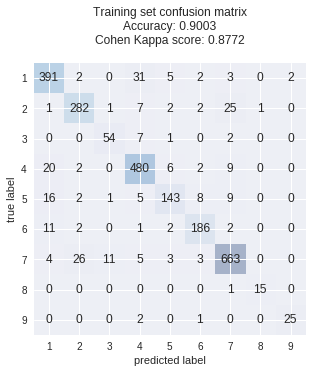

Accuracy:  0.900281463610776
Cohen Kappa score:  0.8772372285823075


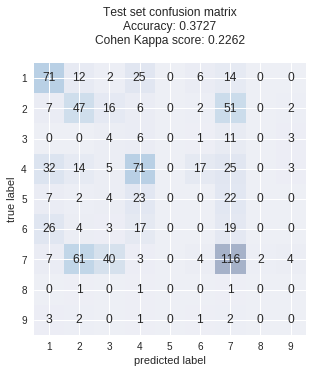

Accuracy:  0.37273823884197826
Cohen Kappa score:  0.22621686677783615


In [227]:

plot_confusion_matrix(confusion_matrix(y_train_new, y_pred_train_new_classes + 1), figsize=(5,5))
plt.title('Training set confusion matrix\nAccuracy: {}\nCohen Kappa score: {}'.format(
                 round(accuracy_score(y_pred=y_pred_train_new_classes + 1,y_true=y_train_new),4), 
                  round(cohen_kappa_score(labels=range(1,10),y1 = y_pred_train_new_classes + 1, y2 = y_train_new),4)))


plt.xticks(range(0,9), range(1,10))
plt.yticks(range(0,9), range(1,10))

plt.show()

print('Accuracy: ', accuracy_score(y_pred=y_pred_train_new_classes + 1,
                                   y_true=y_train_new))
print('Cohen Kappa score: ', cohen_kappa_score(labels=range(1,10),
                  y1 = y_pred_train_new_classes + 1, 
                  y2 = y_train_new))


plot_confusion_matrix(confusion_matrix(y_test_new, y_pred_test_new_classes + 1),figsize=(5,5))

plt.title('Test set confusion matrix\nAccuracy: {}\nCohen Kappa score: {}'.format(
                 round(accuracy_score(y_pred=y_pred_test_new_classes + 1,y_true=y_test_new),4), 
                  round(cohen_kappa_score(labels=range(1,10),y1 = y_pred_test_new_classes + 1, y2 = y_test_new),4)))

plt.xticks(range(0,9), range(1,10))
plt.yticks(range(0,9), range(1,10))

plt.show()

print('Accuracy: ', accuracy_score(y_pred=y_pred_test_new_classes + 1,
                                   y_true=y_test_new))
print('Cohen Kappa score: ', cohen_kappa_score(labels=range(1,10),
                  y1 = y_pred_test_new_classes + 1, 
                  y2 = y_test_new))

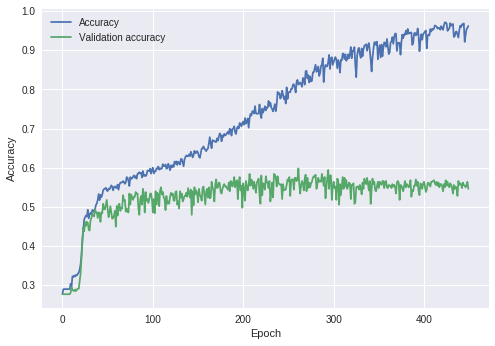

In [212]:
plt.plot(lstm02_callbacks.history['acc']+lstm02_callbacks2.history['acc']+lstm02_callbacks3.history['acc'], label='Accuracy')
plt.plot(lstm02_callbacks.history['val_acc']+lstm02_callbacks2.history['val_acc']+lstm02_callbacks3.history['val_acc'], label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
#plt.show()

In [229]:
print(f1_score(y_pred=y_pred_train_new_classes + 1,y_true=y_train_new, average='weighted'))
print(f1_score(y_pred=y_pred_test_new_classes + 1 ,y_true=y_test_new, average='weighted'))

0.8999782439634743
0.3579099859983517


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Mounting Google Drive on Google Colab

In [5]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive


In [8]:
!pip install gensim

    100% |████████████████████████████████| 22.6MB 60kB/s 
    100% |████████████████████████████████| 1.4MB 847kB/s 
    100% |████████████████████████████████| 133kB 7.8MB/s 
    100% |████████████████████████████████| 4.2MB 327kB/s 
    100% |████████████████████████████████| 61kB 9.8MB/s 
    100% |████████████████████████████████| 552kB 2.5MB/s 
  Running setup.py bdist_wheel for smart-open ... - done
  Stored in directory: /content/.cache/pip/wheels/b1/9e/7d/bb3d3b55c597e72617140a0638c06382a5f17283881eae163e
  Running setup.py bdist_wheel for bz2file ... - done
  Stored in directory: /content/.cache/pip/wheels/81/75/d6/e1317bf09bf1af5a30befc2a007869fa6e1f516b8f7c591cb9
Successfully built smart-open bz2file
You are using pip version 9.0.3, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


    100% |████████████████████████████████| 1.3MB 845kB/s 
You are using pip version 9.0.3, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
